In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Read and Explore

In [2]:
trainData = pd.read_csv('train.txt', header=None, 
                    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                           'marital-status', 'occupation', 'relationship','race',
                          'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                          'native-country', 'income'])

testData = pd.read_csv('test.txt', header=None, 
                    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                           'marital-status', 'occupation', 'relationship','race',
                          'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
                          'native-country'])


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,34,Private,287315,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,43,Federal-gov,145175,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,42,United-States,>50K
2,45,Local-gov,33798,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,23,Private,180497,Bachelors,13,Never-married,Tech-support,Own-child,Black,Female,0,0,32,United-States,<=50K
4,65,Self-emp-not-inc,145628,10th,6,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K


## Process

In [3]:
# use only continous variables
contVar = ['fnlwgt', 'education-num',
            'capital-gain','capital-loss', 'hours-per-week', 'income']
train = trainData[contVar]
test = testData[contVar[:-1]]

# target: income change ' <=50K' and ' >50K' into -1 and 1
labels = np.where(train.income == ' <=50K', -1, 1)
train = train.drop('income', axis=1)

In [4]:
# unit variance, zero-mean scaling
scaleTrain = (train-train.mean())/train.std()
scaleTest = (test-test.mean())/test.std()

## Batch

In [164]:
def svm(a, b, x, y, reg = 1e-2, n=1000, m=0.05, epoch = 1):
    accuracies = []

    # select batch
    train, _, labels, _ = train_test_split(x, y, test_size=300)

    # predict and concat with zero column
    pred = (np.dot(train, a) + b)*labels
    pred0 = np.vstack((1-pred, np.zeros(pred.shape)) ).T

    # calculate total loss
    loss = np.mean(np.max(pred0, axis=1))+ reg*np.dot(a, a.T)/2

    # count positie, negative numbers for repeat
    pos = np.sum(pred>=1)
    neg = np.sum(pred<1)

    # calculate gradient
    gradientA = np.zeros((pred.shape[0], len(a) ) )
    gradientB = np.zeros(pred.shape)
    gradientA[pred>=1] = np.repeat(reg*a, pos).reshape(-1,5)
    gradientA[pred<1] = (reg*a-np.multiply(labels.reshape(-1,1), train))[pred<1]
    gradientB[pred<1] = -labels[pred<1]

    # step size
    alpha = m/(epoch+n)

    # update coef
    gradA = np.mean(gradientA, axis=0)
    gradB = np.mean(gradientB)
    a -= alpha*gradA
    b -= alpha*gradB

    return (a,b, accuracies)

In [214]:
%%time
# split validation and train set
train, val, train_labels, val_labels = train_test_split(scaleTrain, labels, test_size=0.1)

epochs = 50
steps = 600
n = 10000
m = 5
regs =  [1e-3, 1e-2, 1e-1, 1]
accuracies = []
coefficients = []
# loop over reg
for reg in regs:
    print('reg: '+str(reg))
    
    # random create coef a and b
    a = np.random.rand(train.shape[1])
    b = np.random.rand(1)

    # loop over epochs
    for epoch in np.arange(epochs):

        # seperate out 50 hold out random
        epochData, hold, epochLabels, holdLabels = train_test_split(train, train_labels, test_size=50)
        

        # loop over steps
        for step in np.arange(steps):

            # train model
            a, b, accuracy = svm(a, b, epochData, epochLabels, reg = reg, n=n, m=m, epoch = epoch)
            if step % 30 ==0:
                holdPred = np.where(np.dot(hold, a)+b >=0, 1, -1)
                accuracy = np.mean(holdPred==holdLabels)
                accuracies.append(accuracy)
                coefficients.extend(a)
                # print('iter: '+str(epoch) +', accuracy = '+str(accuracy))
            
        
    # validation test
    pred = np.dot(val, a)+b
    pred = np.where(pred>=0, 1, -1)
    print("validation accuracy: " + str(np.mean(pred==val_labels) ) )

reg: 0.001
validation accuracy: 0.802547770700637
reg: 0.01
validation accuracy: 0.801410373066424
reg: 0.1
validation accuracy: 0.785031847133758
reg: 1
validation accuracy: 0.7700181983621474
Wall time: 24min 30s


## Plot

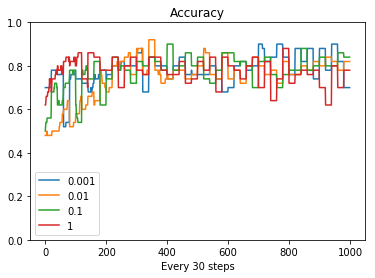

In [215]:
# plot accuracy
% matplotlib inline
accuracies = np.array(accuracies).reshape(-1, int(epochs*steps/30))
for accuracy in accuracies:
    plt.plot(accuracy)
plt.legend(regs)
plt.title('Accuracy')
plt.xlabel('Every 30 steps')
plt.ylim([0,1])
plt.show()

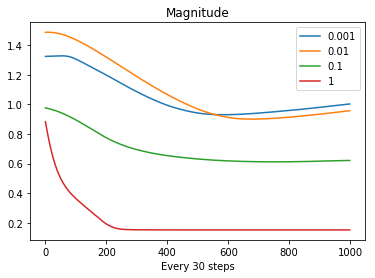

In [249]:
# calculate magnitudes
magnitudes = np.array(coefficients).reshape(-1,5)
magnitudes = [np.sqrt(np.dot(a, a.T)) for a in magnitudes]

# plot magnitude
% matplotlib inline

magnitudes = np.array(magnitudes).reshape(-1, int(epochs*steps/30))
for magnitude in magnitudes:
    plt.plot(magnitude)
plt.legend(regs)
plt.title('Magnitude')
plt.xlabel('Every 30 steps')
plt.ylim()
plt.show()

## Predict

In [252]:
# random create coef a and b
a = np.random.rand(train.shape[1])
b = np.random.rand(1)

for epoch in np.arange(epochs):
    for step in np.arange(steps):
        # train model
        a, b, accuracy = svm(a, b, scaleTrain, labels, reg = reg, n=n, m=m, epoch = epoch)

In [251]:
pred = np.dot(scaleTest, a)+b
pred = np.where(pred>=0, 1, -1)

# save to text
testLabels = np.where(pred==1, '>50K', "<=50K")
np.savetxt('submission.txt',testLabels, fmt='%s')

## Stochastic

In [154]:
# stochastic
reg = 1e-3

n,m = train.shape

# random create coef a and b

a = np.random.rand(train.shape[1])
b = np.random.rand(1)

accuracies= []

for epoch in np.arange(5):
    loss= []
    # seperate out 50 hold out random
    epochData, hold, epochLabels, holdLabels = train_test_split(scaleTrain, labels, test_size=50)
    
    for i in np.arange(train.shape[0]):
        pred = (np.dot(epochData.iloc[i,:], a) + b)*epochLabels[i]
        pred0 = np.append((1-pred), 0)
        if pred >= 1:
            gradA = reg*a
            gradB = 0
        else:
            gradA = reg*a-np.dot(epochLabels[i], epochData.iloc[i,:])
            gradB = -labels[i]
        

        # calculate individual loss
        loss.append(np.max(pred0))
        
        # calculate step
        step = m/(epoch+n)
        
        # update coef
        a -= step*gradA
        b -= step*gradB
    
    loss = np.mean(loss)+ reg*np.dot(a, a.T)/2
    
    # calculate holdout accuracy
    holdPred = np.where(np.dot(hold, a)+b >=0, 1, -1)
    accuracy = np.mean(holdPred==holdLabels)
    accuracies.append(accuracy)
    print(a)
    print('iter: '+str(epoch) +', accuracy = '+str(accuracy) +", step:"+str(step))

[0.07414601 0.41389805 1.09909205 0.234201   0.24169258]
iter: 0, accuracy = 0.84, step:0.0001263870984049948
[0.02717608 0.69580001 1.13290696 0.26710634 0.37375594]
iter: 1, accuracy = 0.84, step:0.0001263839037460189
[0.0131387  1.07319644 1.17395887 0.34867217 0.55718575]
iter: 2, accuracy = 0.76, step:0.00012638070924854032
[0.00353512 1.43498834 1.22113017 0.40765093 0.74078075]
iter: 3, accuracy = 0.82, step:0.00012637751491254676
[0.00423621 1.7711554  1.27252699 0.45156174 0.90999617]
iter: 4, accuracy = 0.74, step:0.00012637432073802604
